In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Remove warnings about deprecated features
import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader, TensorDataset
from ml.models.multi_step_lstm import MultiStepLSTM
from ml.utils.data_utils import prepare_dataset
from argparse import Namespace
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Testing the prepare_dataset function with a sample configuration

args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True
)

# Prepare the dataset
# This will load the dataset, scale the features and targets, and split into training and test sets
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train targets shape: {y_train.shape}, Test targets shape: {y_test.shape}")
print(f"Train IDs shape: {id_train.shape}, Test IDs shape: {id_test.shape}")


Train shape: (21596, 10, 6), Test shape: (5399, 10, 6)
Train targets shape: (21596, 6, 5), Test targets shape: (5399, 6, 5)
Train IDs shape: (21596,), Test IDs shape: (5399,)


## Process data

In [ ]:
## Configuration

args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    epochs=10,
    batch_size=64,
    lr=0.001,
    hidden_size=128,
    num_layers=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [4]:
# Prepare Data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

In [ ]:
# Create DataLoaders for training and testing
train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=args.batch_size)

## Model Train

In [ ]:
# Initialize the model
input_dim = X_train.shape[2]
output_dim = y_train.shape[2]
model = MultiStepLSTM(input_size=input_dim, hidden_size=args.hidden_size, num_layers=args.num_layers,
                      output_size=output_dim, forecast_steps=args.forecast_steps).to(args.device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.MSELoss()

In [7]:
for epoch in range(args.epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(args.device), yb.to(args.device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[{epoch+1}/{args.epochs}] Train Loss: {total_loss/len(train_loader):.4f}")

[1/10] Train Loss: 0.0202
[2/10] Train Loss: 0.0155
[3/10] Train Loss: 0.0133
[4/10] Train Loss: 0.0119
[5/10] Train Loss: 0.0113
[6/10] Train Loss: 0.0112
[7/10] Train Loss: 0.0110
[8/10] Train Loss: 0.0108
[9/10] Train Loss: 0.0107
[10/10] Train Loss: 0.0107


In [8]:
# Save model
torch.save(model.state_dict(), "multi_step_lstm.pt")

## Evaluation

In [9]:
import torch
from ml.models.multi_step_lstm import MultiStepLSTM
from ml.utils.data_utils import prepare_dataset
from argparse import Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [10]:
args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    hidden_size=128,
    num_layers=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [11]:
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)


In [12]:
input_dim = X_test.shape[2]
output_dim = y_test.shape[2]
model = MultiStepLSTM(input_size=input_dim, hidden_size=args.hidden_size, num_layers=args.num_layers,
                      output_size=output_dim, forecast_steps=args.forecast_steps).to(args.device)


In [13]:
model.load_state_dict(torch.load("multi_step_lstm.pt"))
model.eval()

MultiStepLSTM(
  (lstm): LSTM(6, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=30, bias=True)
)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the trained model on test data
with torch.no_grad():
    preds = model(torch.Tensor(X_test).to(args.device)).cpu().numpy()
    y_true = y_test

    # Reshape for evaluation: [samples × steps, targets]
    preds_flat = preds.reshape(-1, preds.shape[-1])
    y_true_flat = y_true.reshape(-1, y_true.shape[-1])

    print("\nEvaluation Metrics for All 5 Targets (Flattened over Time Steps):")
    for i, var in enumerate(args.targets):
        true_vals = y_true_flat[:, i]
        pred_vals = preds_flat[:, i]
        
        mse = mean_squared_error(true_vals, pred_vals)
        rmse = mean_squared_error(true_vals, pred_vals, squared=False)
        mae = mean_absolute_error(true_vals, pred_vals)
        r2 = r2_score(true_vals, pred_vals)
        nrmse = rmse / (true_vals.max() - true_vals.min())

        print(f"\n{var} Metrics:")
        print(f"  MSE   : {mse:.4f}")
        print(f"  RMSE  : {rmse:.4f}")
        print(f"  MAE   : {mae:.4f}")
        print(f"  R²    : {r2:.4f}")
        print(f"  NRMSE : {nrmse:.4f}")



Evaluation Metrics for All 5 Targets (Flattened over Time Steps):

rnti_count Metrics:
  MSE   : 0.0077
  RMSE  : 0.0875
  MAE   : 0.0674
  R²    : 0.5108
  NRMSE : 0.1222

rb_down Metrics:
  MSE   : 0.0110
  RMSE  : 0.1050
  MAE   : 0.0564
  R²    : 0.4162
  NRMSE : 0.1052

rb_up Metrics:
  MSE   : 0.0180
  RMSE  : 0.1341
  MAE   : 0.0672
  R²    : 0.4231
  NRMSE : 0.1341

down Metrics:
  MSE   : 0.0091
  RMSE  : 0.0952
  MAE   : 0.0593
  R²    : 0.3587
  NRMSE : 0.0955

up Metrics:
  MSE   : 0.0153
  RMSE  : 0.1237
  MAE   : 0.0628
  R²    : 0.3648
  NRMSE : 0.1237


## Visualization

In [15]:
# ─────────────────────────────────────────────────────────────
# STEP 6: Visualizations

def plot_all_steps(preds, y_test, var_name):
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(6):
        axs[t].plot(preds[:, t, idx], label='Predicted', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    idx = args.targets.index(var_name)
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 7), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, 7), preds[sample_idx, :, idx], label="Predicted", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+")
    plt.ylabel("Scaled value")
    plt.xticks(range(1, 7))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Forecast plots for rb_down


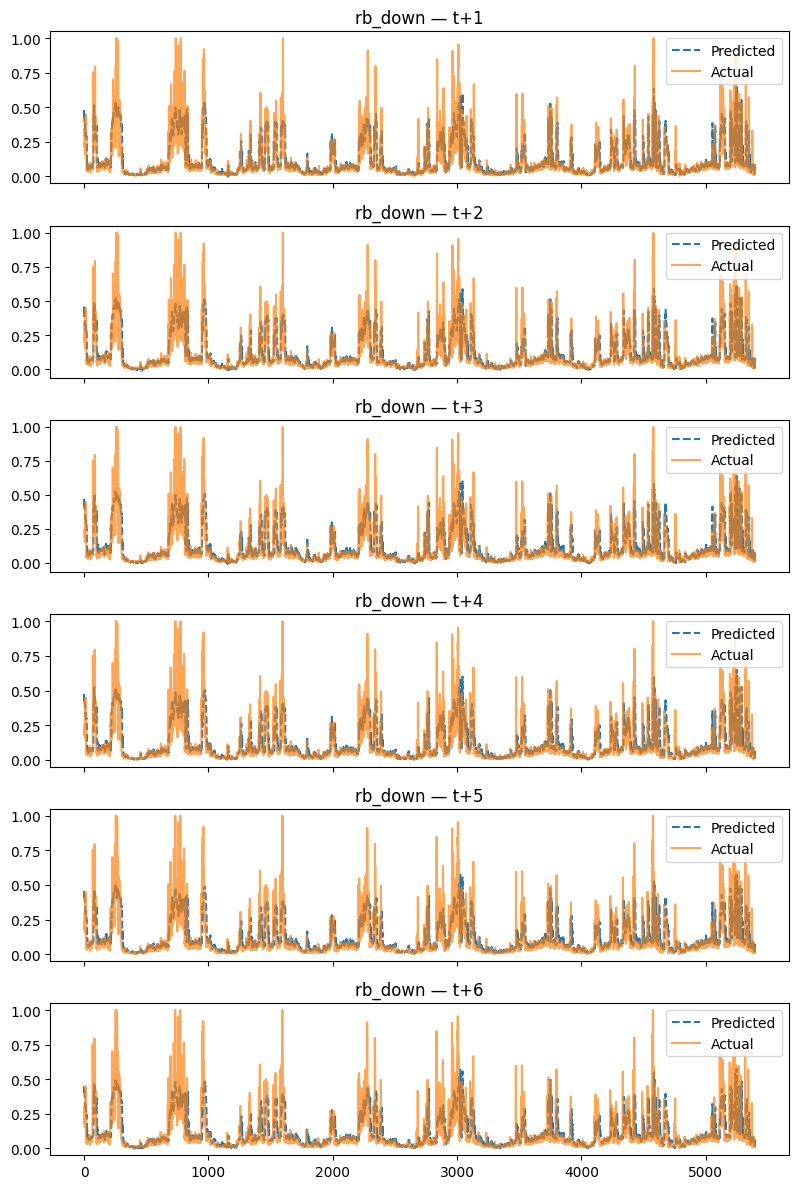

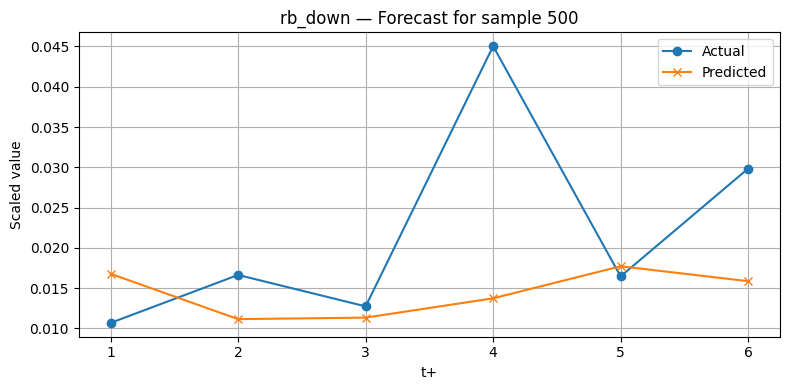


Forecast plots for down


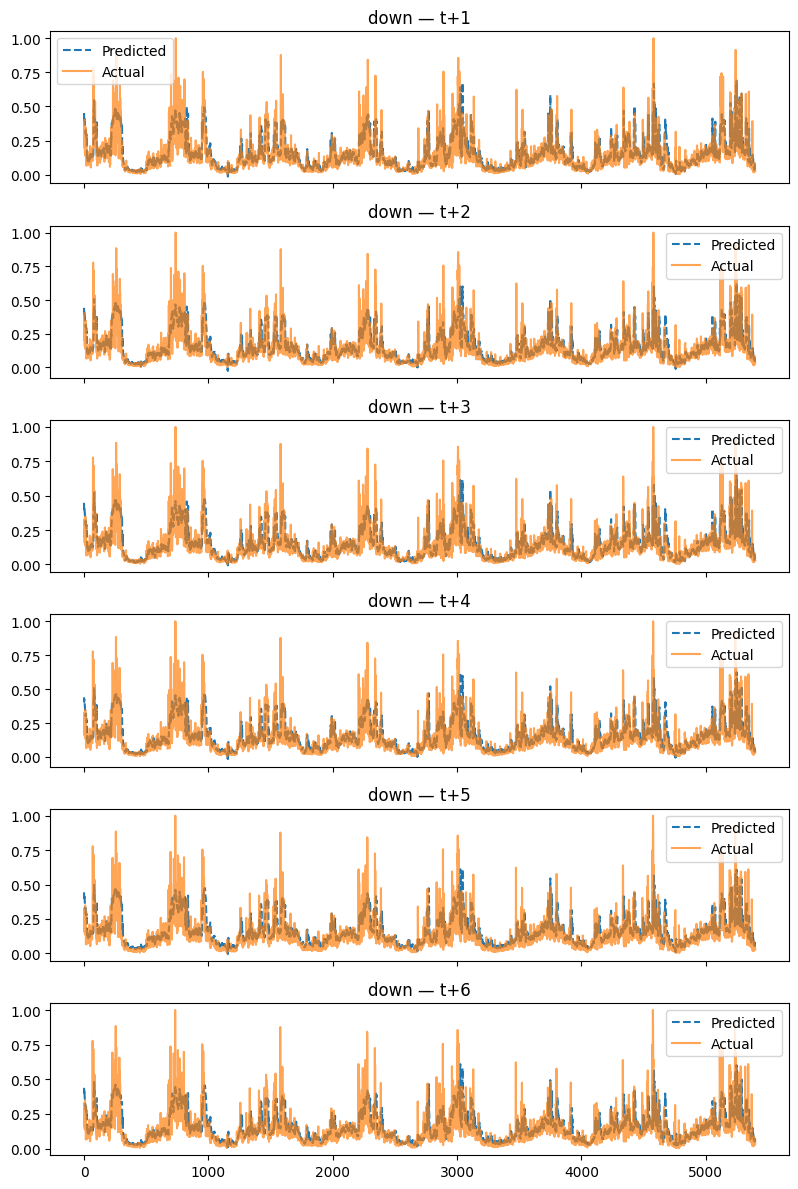

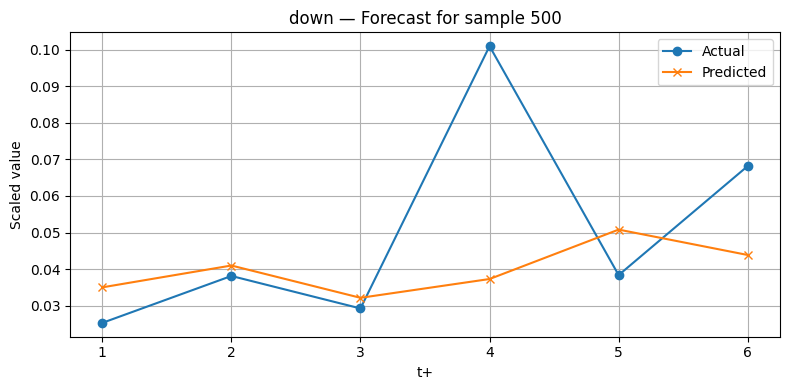

In [16]:
# ───────────── Plot both variables ─────────────
for var in ['rb_down', 'down']:
    print(f"\nForecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)